<h1 align="center"> Image Captioning (10 баллов) </h1>

В этом ноутбуке вы обучите сеть составлять подписи к изображениям.
![img](https://i.imgur.com/obITaMl.png)


#### План работы:

1. Использовать предобученную модель Inception v3 для преобразования изображений в векторы.

2. Добавить поверх неё LSTM.

3. Обучить модель на датасете [MSCOCO](http://cocodataset.org/#download).

### 1. Данные (0.5 балла)

In [4]:
# Скачайте датасет по ссылке https://drive.google.com/file/d/1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO/view?usp=sharing

In [2]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: total: 766 ms
Wall time: 802 ms



Чтобы сэкономить ваше время, мы уже преобразовали все изображения из MSCOCO17 в векторы с помощью предобученной сети Inception_v3 из библиотеки [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

Весь процесс занимает от одного дня на CPU до примерно 10 минут на трёх GPU Tesla M40. [Если хотите попробовать сделать это самостоятельно — пожалуйста.](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).


In [3]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как видно, все подписи уже токенизированы и приведены к нижнему регистру. Теперь нам нужно разделить их и добавить специальные токены, обозначающие начало и конец подписи.

In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


Мы не хотим, чтобы сеть на каждом шаге предсказывала вероятности для миллиона слов, поэтому нужно немного сократить словарь.

Для этого посчитайте, **сколько раз встречается каждое слово** — так мы сможем решить, какие слова оставить в словаре.

In [130]:

from collections import Counter
word_counts = Counter()

for img_captions in captions:
    for caption in img_captions:
        if isinstance(caption, list):
            word_counts.update(caption)
        else:
            words = caption.lower().split()
            word_counts.update(words)

In [6]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [7]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [8]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### 2. Построение нейронной сети (1.5 балла)

Как уже упоминалось, мы создадим RNN-модель для генерации текста, которая будет зависеть от векторов, полученных из CNN-части сети.

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

Во время обучения мы будем использовать уже готовые вектора-признаков, а сеть Inception добавим на этапе инференса.


In [9]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CaptionNet(nn.Module):
    def __init__(self, n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        super().__init__()
        
        # Linear layers to convert CNN features to LSTM initial state
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # Word embeddings
        self.emb = nn.Embedding(n_tokens, emb_size)
        
        # LSTM layer 
        self.lstm = nn.LSTM(
            input_size=emb_size,      # Размерность эмбеддингов
            hidden_size=lstm_units,   # Размерность скрытого состояния
            batch_first=True,         # Формат данных: [batch, seq, features]
            dropout=0.1               # Добавлю dropout
        )
        
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, img_features, captions_ix):
        batch_size = img_features.shape[0]
        
        h0 = self.cnn_to_h0(img_features).unsqueeze(0)  # [1, batch_size, lstm_units]
        c0 = self.cnn_to_c0(img_features).unsqueeze(0)  # [1, batch_size, lstm_units]
        
        captions_emb = self.emb(captions_ix)  # [batch_size, seq_len, emb_size]
        
        lstm_out, _ = self.lstm(captions_emb, (h0, c0))  # [batch_size, seq_len, lstm_units]
        
        logits = self.logits(lstm_out)  # [batch_size, seq_len, n_tokens]
        
        return logits

In [132]:
network = CaptionNet(n_tokens)

In [133]:
def compute_loss(network, image_vectors, captions_ix):
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()

    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)


    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    loss_sum = F.cross_entropy(
        logits_for_next.view(-1, logits_for_next.shape[-1]),  
        captions_ix_next.view(-1),                            
        ignore_index=pad_ix,                                  # игнорируем паддинг
        reduction='sum'
    )
    
    non_pad_mask = (captions_ix_next != pad_ix)
    num_non_pad_tokens = non_pad_mask.sum().float()
    
    loss = loss_sum / num_non_pad_tokens
    
    return loss.unsqueeze(0)  

In [134]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'


Добавьте ~~adam~~ ваш любимы оптимизатор для обучения.

In [135]:
import torch.optim as optim
optimizer = optim.AdamW(
    network.parameters(), 
    lr=0.001,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,       
    epochs=n_epochs,
    steps_per_epoch=n_batches_per_epoch,
    pct_start=0.3,     
    div_factor=25,     
    final_div_factor=1e4
)

### 3. Обучение (5 баллов)

* Сначала реализуйте генератор батчей.
* Затем обучите сеть как обычно.

In [136]:
from sklearn.model_selection import train_test_split

train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(
    img_codes, 
    captions,  # передаем как список
    test_size=0.1,
    random_state=42
)

In [139]:
from random import choice
import numpy as np

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

    indices = np.random.choice(len(img_codes), batch_size, replace=False)
    
    batch_images = img_codes[indices]
    captions_for_batch_images = [captions[i] for i in indices]
    
    # Выбор случайных caption с контролем длины
    batch_captions = []
    for img_captions in captions_for_batch_images:
        caption = choice(img_captions)
        # Фильтрация слишком коротких caption
        if len(caption) >= 3:  # минимум 3 слова
            batch_captions.append(caption)
        else:
            # Запасной вариант
            batch_captions.append(max(img_captions, key=len))
    
    batch_captions_ix = as_matrix(batch_captions, max_len=max_caption_len)
    
    device = next(network.parameters()).device
    return (torch.tensor(batch_images, dtype=torch.float32, device=device),
            torch.tensor(batch_captions_ix, dtype=torch.int64, device=device))

In [140]:
generate_batch(img_codes,captions,3)

(tensor([[0.2212, 0.5680, 0.2419,  ..., 0.2408, 0.0132, 0.8043],
         [0.3233, 0.1469, 1.2381,  ..., 0.1481, 1.2085, 0.8330],
         [0.5821, 0.3515, 0.1223,  ..., 0.0054, 0.0913, 0.3027]]),
 tensor([[   1,    7, 1162,   41,    6,   24,  127,   15,   54,  316,   12,    2,
             3],
         [   1,   24,  106,   14,    4,  140,   18,   24,   71,   12,    2,    3,
             3],
         [   1,   24,  718,    6,   24,  718,  717,   15,  210,  413,   15, 1020,
             2]]))

Обучайте модель на мини-батчах, как обычно. Периодически проверяйте качество на валидационном наборе.

#### **Советы**

* Если тренировочный лосс почти равен нулю или модель генерирует бессмысленный текст — проверьте, что вы предсказываете следующее слово, а не текущее или слово через два шага.

* Если модель создаёт плавные, но нерелевантные описания:

  * возможно, рекуррентная сеть не получает векторы изображения;

  * также это может быть следствием взрыва градиентов — попробуйте клиппинг или перезапуск обучения;

  * наконец, возможно, модель просто нужно обучить дольше.

* Кросс-энтропия — слабый показатель переобучения:

  * модель может переобучиться по валидационной кросс-энтропии, но при этом продолжать улучшать качество генерации;

  * используйте ручную оценку или автоматические метрики, такие как CIDEr или BLEU.

* Рекомендуется периодически проверять сеть с помощью блока “apply trained model” — можно остановить обучение, протестировать несколько примеров и продолжить.

* Типичные значения функции потерь: около 3–5, если усреднять по времени,
или масштабировать по длине при суммировании. Разумные подписи начинают появляться при лоссе 2.8–3.0.

In [141]:
from tqdm import tqdm
import torch.optim as optim
import numpy as np

# Параметры обучения
batch_size = 50
n_epochs = 100
n_batches_per_epoch = 50
n_validation_batches = 5
grad_clip_value = 1.0 

# История
train_loss_history = []
val_loss_history = []
best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 7

for epoch in range(n_epochs):
    train_loss = 0
    network.train(True)
    
    for batch_idx in tqdm(range(n_batches_per_epoch), desc=f"Epoch {epoch+1}"):
        try:
            batch_images, batch_captions = generate_batch(train_img_codes, train_captions, batch_size)
            loss_t = compute_loss(network, batch_images, batch_captions)
            
            optimizer.zero_grad()
            loss_t.backward()
            
            torch.nn.utils.clip_grad_norm_(network.parameters(), grad_clip_value)
            
            optimizer.step()
            train_loss += loss_t.item()
                
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            continue

    train_loss /= n_batches_per_epoch
    train_loss_history.append(train_loss)
    
    val_loss = 0
    network.train(False)
    
    with torch.no_grad():
        for _ in range(n_validation_batches):
            batch_images, batch_captions = generate_batch(val_img_codes, val_captions, batch_size)
            loss_t = compute_loss(network, batch_images, batch_captions)
            val_loss += loss_t.item()
    
    val_loss /= n_validation_batches
    val_loss_history.append(val_loss)
    
    scheduler.step(val_loss)
    
    print(f'\nEpoch: {epoch+1:03d}')
    print(f'Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}')
    print(f'Learning rate: {optimizer.param_groups[0]["lr"]:.2e}')
    
    # Early stopping
    if val_loss < best_val_loss * 0.999:  # Минимальное улучшение 0.1%
        best_val_loss = val_loss
        torch.save({
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch,
            'best_val_loss': best_val_loss,
            'train_history': train_loss_history,
            'val_history': val_loss_history
        }, 'best_caption_model.pth')
        patience_counter = 0
        print(f'New best model saved! Val loss: {val_loss:.4f}')
    else:
        patience_counter += 1
        # Уменьшение LR при плато
        if patience_counter >= early_stopping_patience // 2:
            scheduler.step()  # Дополнительное уменьшение LR

print("Training finished!")

Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.99it/s]



Epoch: 001
Train loss: 7.2609, Val loss: 5.4160
Learning rate: 4.00e-04
New best model saved! Val loss: 5.4160


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.78it/s]



Epoch: 002
Train loss: 5.1318, Val loss: 5.0459
Learning rate: 4.00e-04
New best model saved! Val loss: 5.0459


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.58it/s]



Epoch: 003
Train loss: 4.8280, Val loss: 4.7465
Learning rate: 4.00e-04
New best model saved! Val loss: 4.7465


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.59it/s]



Epoch: 004
Train loss: 4.6958, Val loss: 4.7976
Learning rate: 4.00e-04


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.83it/s]



Epoch: 005
Train loss: 4.5719, Val loss: 4.5848
Learning rate: 4.00e-04
New best model saved! Val loss: 4.5848


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.34it/s]



Epoch: 006
Train loss: 4.4458, Val loss: 4.4104
Learning rate: 4.00e-04
New best model saved! Val loss: 4.4104


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.56it/s]



Epoch: 007
Train loss: 4.3950, Val loss: 4.2819
Learning rate: 4.00e-04
New best model saved! Val loss: 4.2819


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.33it/s]



Epoch: 008
Train loss: 4.3100, Val loss: 4.2789
Learning rate: 4.00e-04


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.54it/s]



Epoch: 009
Train loss: 4.2183, Val loss: 4.2806
Learning rate: 4.00e-04


Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.55it/s]



Epoch: 010
Train loss: 4.1868, Val loss: 4.1531
Learning rate: 4.00e-04
New best model saved! Val loss: 4.1531


Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.70it/s]



Epoch: 011
Train loss: 4.1031, Val loss: 4.0940
Learning rate: 4.00e-04
New best model saved! Val loss: 4.0940


Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.57it/s]



Epoch: 012
Train loss: 4.0642, Val loss: 4.1033
Learning rate: 4.00e-04


Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.69it/s]



Epoch: 013
Train loss: 4.0453, Val loss: 4.0319
Learning rate: 4.00e-04
New best model saved! Val loss: 4.0319


Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]



Epoch: 014
Train loss: 3.9619, Val loss: 3.9981
Learning rate: 4.00e-04
New best model saved! Val loss: 3.9981


Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]



Epoch: 015
Train loss: 3.9207, Val loss: 3.9783
Learning rate: 4.00e-04
New best model saved! Val loss: 3.9783


Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]



Epoch: 016
Train loss: 3.8737, Val loss: 3.9342
Learning rate: 4.00e-04
New best model saved! Val loss: 3.9342


Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.68it/s]



Epoch: 017
Train loss: 3.8516, Val loss: 3.8100
Learning rate: 4.00e-04
New best model saved! Val loss: 3.8100


Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.42it/s]



Epoch: 018
Train loss: 3.8169, Val loss: 3.8699
Learning rate: 4.00e-04


Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.60it/s]



Epoch: 019
Train loss: 3.7537, Val loss: 3.7536
Learning rate: 4.00e-04
New best model saved! Val loss: 3.7536


Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.51it/s]



Epoch: 020
Train loss: 3.7283, Val loss: 3.6719
Learning rate: 4.00e-04
New best model saved! Val loss: 3.6719


Epoch 21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.64it/s]



Epoch: 021
Train loss: 3.7317, Val loss: 3.7548
Learning rate: 4.00e-04


Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.56it/s]



Epoch: 022
Train loss: 3.7057, Val loss: 3.6499
Learning rate: 4.00e-04
New best model saved! Val loss: 3.6499


Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.53it/s]



Epoch: 023
Train loss: 3.6518, Val loss: 3.7703
Learning rate: 4.00e-04


Epoch 24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.46it/s]



Epoch: 024
Train loss: 3.6127, Val loss: 3.6102
Learning rate: 4.00e-04
New best model saved! Val loss: 3.6102


Epoch 25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.49it/s]



Epoch: 025
Train loss: 3.5997, Val loss: 3.6428
Learning rate: 4.00e-04


Epoch 26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]



Epoch: 026
Train loss: 3.5789, Val loss: 3.6133
Learning rate: 4.00e-04


Epoch 27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.30it/s]



Epoch: 027
Train loss: 3.5260, Val loss: 3.5269
Learning rate: 4.00e-04
New best model saved! Val loss: 3.5269


Epoch 28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.67it/s]



Epoch: 028
Train loss: 3.5211, Val loss: 3.4956
Learning rate: 4.00e-04
New best model saved! Val loss: 3.4956


Epoch 29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.08it/s]



Epoch: 029
Train loss: 3.5456, Val loss: 3.4889
Learning rate: 4.00e-04
New best model saved! Val loss: 3.4889


Epoch 30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.23it/s]



Epoch: 030
Train loss: 3.4902, Val loss: 3.5623
Learning rate: 4.00e-04


Epoch 31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.58it/s]



Epoch: 031
Train loss: 3.4953, Val loss: 3.3920
Learning rate: 4.00e-04
New best model saved! Val loss: 3.3920


Epoch 32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]



Epoch: 032
Train loss: 3.4398, Val loss: 3.5060
Learning rate: 4.00e-04


Epoch 33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.49it/s]



Epoch: 033
Train loss: 3.4233, Val loss: 3.3915
Learning rate: 4.00e-04


Epoch 34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.73it/s]



Epoch: 034
Train loss: 3.3492, Val loss: 3.4315
Learning rate: 4.00e-04


Epoch 35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.62it/s]



Epoch: 035
Train loss: 3.4050, Val loss: 3.3220
Learning rate: 4.00e-04
New best model saved! Val loss: 3.3220


Epoch 36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.51it/s]



Epoch: 036
Train loss: 3.3906, Val loss: 3.2996
Learning rate: 4.00e-04
New best model saved! Val loss: 3.2996


Epoch 37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.72it/s]



Epoch: 037
Train loss: 3.3464, Val loss: 3.3787
Learning rate: 4.00e-04


Epoch 38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.63it/s]



Epoch: 038
Train loss: 3.3619, Val loss: 3.2792
Learning rate: 4.00e-04
New best model saved! Val loss: 3.2792


Epoch 39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.56it/s]



Epoch: 039
Train loss: 3.3109, Val loss: 3.3166
Learning rate: 4.00e-04


Epoch 40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.80it/s]



Epoch: 040
Train loss: 3.2850, Val loss: 3.3061
Learning rate: 4.00e-04


Epoch 41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.59it/s]



Epoch: 041
Train loss: 3.2544, Val loss: 3.3967
Learning rate: 4.00e-04


Epoch 42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.46it/s]



Epoch: 042
Train loss: 3.2345, Val loss: 3.2444
Learning rate: 4.00e-04
New best model saved! Val loss: 3.2444


Epoch 43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.63it/s]



Epoch: 043
Train loss: 3.2503, Val loss: 3.3066
Learning rate: 4.00e-04


Epoch 44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]



Epoch: 044
Train loss: 3.2359, Val loss: 3.2512
Learning rate: 4.00e-04


Epoch 45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.60it/s]



Epoch: 045
Train loss: 3.2117, Val loss: 3.1555
Learning rate: 4.00e-04
New best model saved! Val loss: 3.1555


Epoch 46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.52it/s]



Epoch: 046
Train loss: 3.2307, Val loss: 3.2275
Learning rate: 4.00e-04


Epoch 47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.56it/s]



Epoch: 047
Train loss: 3.2020, Val loss: 3.1307
Learning rate: 4.00e-04
New best model saved! Val loss: 3.1307


Epoch 48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.62it/s]



Epoch: 048
Train loss: 3.2118, Val loss: 3.1905
Learning rate: 4.00e-04


Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.48it/s]



Epoch: 049
Train loss: 3.1846, Val loss: 3.2169
Learning rate: 4.00e-04


Epoch 50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.60it/s]



Epoch: 050
Train loss: 3.1288, Val loss: 3.1307
Learning rate: 4.00e-04


Epoch 51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.69it/s]



Epoch: 051
Train loss: 3.1569, Val loss: 3.1437
Learning rate: 4.00e-04


Epoch 52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.47it/s]



Epoch: 052
Train loss: 3.1317, Val loss: 3.2280
Learning rate: 4.00e-04


Epoch 53: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]



Epoch: 053
Train loss: 3.1424, Val loss: 3.1603
Learning rate: 4.00e-04


Epoch 54: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.64it/s]



Epoch: 054
Train loss: 3.0982, Val loss: 3.1136
Learning rate: 4.00e-04
New best model saved! Val loss: 3.1136


Epoch 55: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.53it/s]



Epoch: 055
Train loss: 3.1195, Val loss: 3.0793
Learning rate: 4.00e-04
New best model saved! Val loss: 3.0793


Epoch 56: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.62it/s]



Epoch: 056
Train loss: 3.0875, Val loss: 3.0780
Learning rate: 4.00e-04


Epoch 57: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.53it/s]



Epoch: 057
Train loss: 3.1180, Val loss: 3.1628
Learning rate: 4.00e-04


Epoch 58: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.48it/s]



Epoch: 058
Train loss: 3.1038, Val loss: 3.2391
Learning rate: 4.00e-04


Epoch 59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]



Epoch: 059
Train loss: 3.0882, Val loss: 3.0011
Learning rate: 4.00e-04
New best model saved! Val loss: 3.0011


Epoch 60: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.36it/s]



Epoch: 060
Train loss: 3.0970, Val loss: 2.9981
Learning rate: 4.00e-04
New best model saved! Val loss: 2.9981


Epoch 61: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.64it/s]



Epoch: 061
Train loss: 3.0732, Val loss: 3.1670
Learning rate: 4.00e-04


Epoch 62: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.47it/s]



Epoch: 062
Train loss: 3.0430, Val loss: 3.0133
Learning rate: 4.00e-04


Epoch 63: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.33it/s]



Epoch: 063
Train loss: 3.0678, Val loss: 3.0287
Learning rate: 4.00e-04


Epoch 64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.61it/s]



Epoch: 064
Train loss: 3.0258, Val loss: 3.1257
Learning rate: 4.00e-04


Epoch 65: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.48it/s]



Epoch: 065
Train loss: 3.0343, Val loss: 3.1061
Learning rate: 4.00e-04


Epoch 66: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.50it/s]



Epoch: 066
Train loss: 3.0280, Val loss: 3.0995
Learning rate: 4.00e-04


Epoch 67: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.60it/s]



Epoch: 067
Train loss: 3.0327, Val loss: 3.0502
Learning rate: 4.00e-04


Epoch 68: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.64it/s]



Epoch: 068
Train loss: 3.0272, Val loss: 3.0601
Learning rate: 4.00e-04


Epoch 69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.71it/s]



Epoch: 069
Train loss: 2.9905, Val loss: 3.1009
Learning rate: 4.00e-04


Epoch 70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.58it/s]



Epoch: 070
Train loss: 3.0296, Val loss: 3.0787
Learning rate: 4.00e-04


Epoch 71: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.57it/s]



Epoch: 071
Train loss: 3.0061, Val loss: 2.9256
Learning rate: 4.00e-04
New best model saved! Val loss: 2.9256


Epoch 72: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.94it/s]



Epoch: 072
Train loss: 2.9932, Val loss: 2.8317
Learning rate: 4.00e-04
New best model saved! Val loss: 2.8317


Epoch 73: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.31it/s]



Epoch: 073
Train loss: 2.9764, Val loss: 2.9580
Learning rate: 4.00e-04


Epoch 74: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.57it/s]



Epoch: 074
Train loss: 2.9563, Val loss: 3.0366
Learning rate: 4.00e-04


Epoch 75: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.63it/s]



Epoch: 075
Train loss: 3.0044, Val loss: 3.0151
Learning rate: 4.00e-04


Epoch 76: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.62it/s]



Epoch: 076
Train loss: 2.9691, Val loss: 2.9459
Learning rate: 4.00e-04


Epoch 77: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.63it/s]



Epoch: 077
Train loss: 2.9802, Val loss: 3.0444
Learning rate: 4.00e-04


Epoch 78: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.49it/s]



Epoch: 078
Train loss: 2.9513, Val loss: 2.9562
Learning rate: 4.00e-04


Epoch 79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]



Epoch: 079
Train loss: 2.9480, Val loss: 2.8786
Learning rate: 4.00e-04


Epoch 80: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.54it/s]



Epoch: 080
Train loss: 2.9264, Val loss: 3.0222
Learning rate: 4.00e-04


Epoch 81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.67it/s]



Epoch: 081
Train loss: 2.9422, Val loss: 2.9556
Learning rate: 4.00e-04


Epoch 82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.58it/s]



Epoch: 082
Train loss: 2.9479, Val loss: 2.8566
Learning rate: 4.00e-04


Epoch 83: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.50it/s]



Epoch: 083
Train loss: 2.9534, Val loss: 2.8468
Learning rate: 4.00e-04


Epoch 84: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.55it/s]



Epoch: 084
Train loss: 2.9105, Val loss: 3.0068
Learning rate: 4.00e-04


Epoch 85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.74it/s]



Epoch: 085
Train loss: 2.8966, Val loss: 2.8360
Learning rate: 4.00e-04


Epoch 86: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.58it/s]



Epoch: 086
Train loss: 2.9110, Val loss: 2.9495
Learning rate: 4.00e-04


Epoch 87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.42it/s]



Epoch: 087
Train loss: 2.9302, Val loss: 2.9337
Learning rate: 4.00e-04


Epoch 88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.70it/s]



Epoch: 088
Train loss: 2.8778, Val loss: 2.9873
Learning rate: 4.00e-04


Epoch 89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.60it/s]



Epoch: 089
Train loss: 2.9020, Val loss: 2.9187
Learning rate: 4.00e-04


Epoch 90: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.59it/s]



Epoch: 090
Train loss: 2.9125, Val loss: 3.0363
Learning rate: 4.00e-04


Epoch 91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.42it/s]



Epoch: 091
Train loss: 2.8926, Val loss: 2.8798
Learning rate: 4.00e-04


Epoch 92: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.64it/s]



Epoch: 092
Train loss: 2.8738, Val loss: 2.8019
Learning rate: 4.00e-04
New best model saved! Val loss: 2.8019


Epoch 93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]



Epoch: 093
Train loss: 2.8704, Val loss: 2.8397
Learning rate: 4.00e-04


Epoch 94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.63it/s]



Epoch: 094
Train loss: 2.8515, Val loss: 2.7976
Learning rate: 4.00e-04
New best model saved! Val loss: 2.7976


Epoch 95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.61it/s]



Epoch: 095
Train loss: 2.8634, Val loss: 3.0037
Learning rate: 4.00e-04


Epoch 96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.60it/s]



Epoch: 096
Train loss: 2.8994, Val loss: 2.8985
Learning rate: 4.00e-04


Epoch 97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.58it/s]



Epoch: 097
Train loss: 2.8232, Val loss: 2.8339
Learning rate: 4.00e-04


Epoch 98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.31it/s]



Epoch: 098
Train loss: 2.8562, Val loss: 2.8584
Learning rate: 4.00e-04


Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]



Epoch: 099
Train loss: 2.8735, Val loss: 2.9418
Learning rate: 4.00e-04


Epoch 100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.77it/s]



Epoch: 100
Train loss: 2.8484, Val loss: 2.9087
Learning rate: 4.00e-04
Training finished!


### 4. Применяем обученную модель (0.5 балла)

Теперь загрузим предобученнную Inceprion модель и посмотрим, на что способна наша модель.


In [142]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torchvision.models.inception import Inception3
from torch.utils.model_zoo import load_url
from warnings import warn

class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    

def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

In [143]:

inception = beheaded_inception_v3().train(False)

#### **Генерируем подписи**

Функция ниже генерирует подписи, выбирая слова на основе вероятностей, предсказанных моделью.

Реализация здесь простая, но неэффективная (её сложность квадратична по числу шагов LSTM).

In [145]:
def generate_caption(network, image, caption_prefix=("#START#",), 
                     t=1.0, sample=True, max_len=100):
   
    if isinstance(image, np.ndarray):
        # Проверяем и исправляем количество каналов
        if image.ndim == 3:
            if image.shape[-1] == 4:
                # Убираем альфа-канал
                image = image[:, :, :3]
            elif image.shape[-1] not in [1, 3]:
                raise ValueError(f"Invalid number of channels: {image.shape[-1]}")
        
        # Нормализация
        if image.dtype == np.uint8:
            image = image.astype(np.float32) / 255.0
        elif image.max() > 1.0:
            image = image.astype(np.float32) / 255.0
        
        if image.ndim == 3:
            image = image.transpose([2, 0, 1])  # HWC -> CHW
            
        image = torch.tensor(image, dtype=torch.float32)
    
    device = next(network.parameters()).device
    image = image.unsqueeze(0).to(device)  # Добавляем batch dimension
    
    with torch.no_grad():
        vectors_8x8, vectors_neck, logits = inception(image)
        caption_prefix = list(caption_prefix)
        
        for _ in range(max_len):
            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.long).to(device)
            
            next_word_logits = network(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits / t, dim=-1).cpu().numpy()
            
            if sample:
                next_word_probs = np.clip(next_word_probs, 1e-8, 1.0)
                next_word_probs /= np.sum(next_word_probs)
                next_word_idx = np.random.choice(len(next_word_probs), p=next_word_probs)
            else:
                next_word_idx = np.argmax(next_word_probs)
            
            next_word = vocab[next_word_idx]
            caption_prefix.append(next_word)
            
            if next_word == "#END#":
                break
        
        return caption_prefix

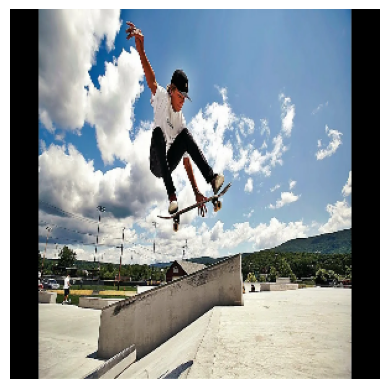

Caption 1: a man riding a skateboard in a park .
Caption 2: a man riding a skateboard on a skateboard .
Caption 3: a man is riding a skateboard on a ramp .
Caption 4: a man riding a skateboard on a skateboard .
Caption 5: a man in a skate board riding a skateboard .
Caption 6: a man is doing a trick on a skateboard .
Caption 7: a man is doing a trick on a skateboard .
Caption 8: a man riding a skateboard on a skateboard .
Caption 9: a man riding a skateboard on a skateboard in the air .
Caption 10: a man is doing a trick on a skateboard .


In [153]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
%matplotlib inline

sample_image = plt.imread('data/img.jpg')
img = cv2.resize(sample_image, (299, 299))

# Нормализация в диапазон [0, 1]
if img.dtype == np.uint8:
    img = img.astype(np.float32) / 255.0
elif img.max() > 1.0:
    img = img.astype(np.float32) / 255.0


# Отображение
plt.imshow(img)
plt.axis('off')
plt.show()

for i in range(10):
    caption = generate_caption(network, img, t=0.4)
    print(f"Caption {i+1}:", ' '.join(caption[1:-1]))

### 5. Demo (2.5 балла)
##### **Найдите как минимум 10 изображений для теста.**

* Серьёзно, это часть задания — подготовьте хотя бы 10 картинок для генерации подписей.

* Сначала проверьте работу модели на простых изображениях, прежде чем переходить к более сложным.

* В вашем наборе должны быть примеры как удачных, так и неудачных подписей — проявите креативность :)

* Используйте фотографии, а не анимацию, 3D или рисунки — иначе придётся переобучать CNN на аниме.

* Обратите внимание на соотношение сторон изображений.

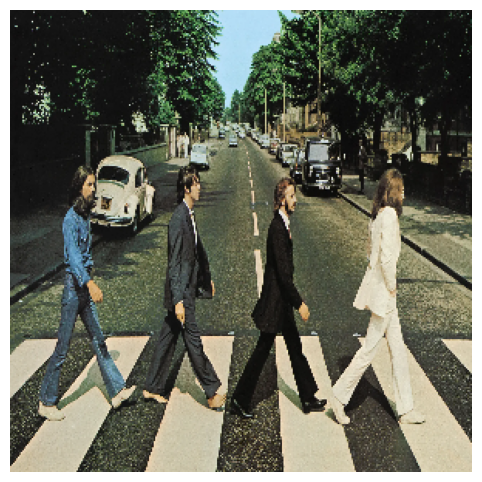

Сгенерированные описания:
  1. a group of people with a person standing on the back of a street
  2. a group of people in a blue shirt on a skateboard
  3. a group of people riding a skateboard on a road .
  4. a group of people standing on a train with a skateboard
  5. a man and woman with a woman standing on a skateboard .


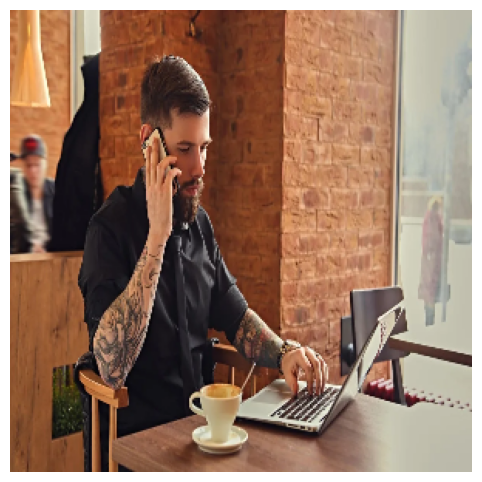

Сгенерированные описания:
  1. a man in a suit holding a laptop .
  2. a man in a suit and tie standing in a room .
  3. a man is sitting on top of a bed .
  4. a man sitting on a table with a laptop .
  5. a woman is sitting at a table with a laptop .


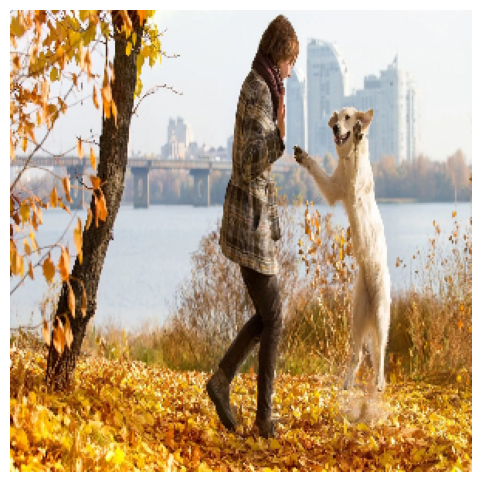

Сгенерированные описания:
  1. a black and white photo of a large white cow .
  2. a white cow is standing in a grassy area .
  3. a couple of sheep standing next to each other .
  4. a small giraffe is standing on a grassy field .
  5. a picture of a bird that is standing in the middle of a dirt road .


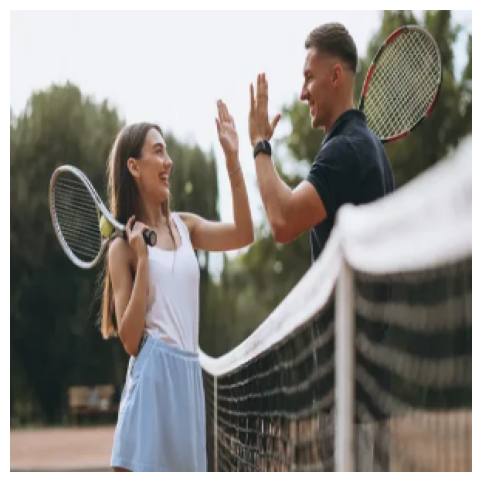

Сгенерированные описания:
  1. a young man standing on a tennis court with a racket .
  2. a tennis player about to hit a ball on a tennis court .
  3. a man and a woman playing a game of tennis .
  4. a woman playing a tennis game with a tennis racquet .
  5. a tennis player is playing a tennis game .


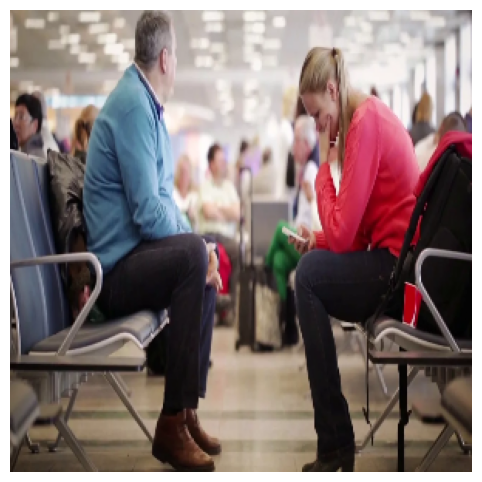

Сгенерированные описания:
  1. a man is sitting on a bench next to a man sitting on a bench .
  2. a man sitting on a bench with a bicycle .
  3. a woman is sitting on the beach with a skateboard .
  4. a man is sitting on a bench with a dog and a woman .
  5. a man is sitting on a bench in a park .


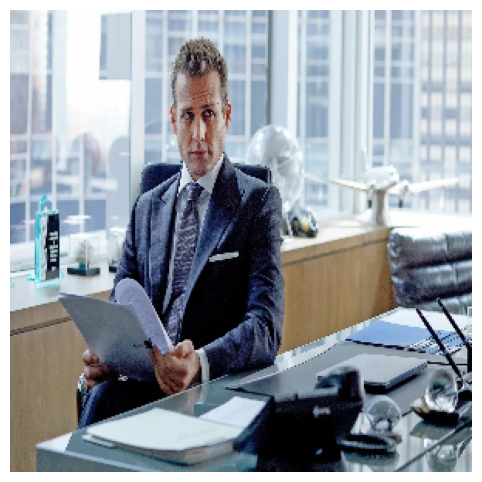

Сгенерированные описания:
  1. a man sitting on a couch with a laptop on the top .
  2. a woman sitting on a laptop computer on a desk
  3. a man in black shirt standing next to a laptop on a table .
  4. a man sitting on a cell phone with a laptop .
  5. a man sitting at a table with a laptop computer .


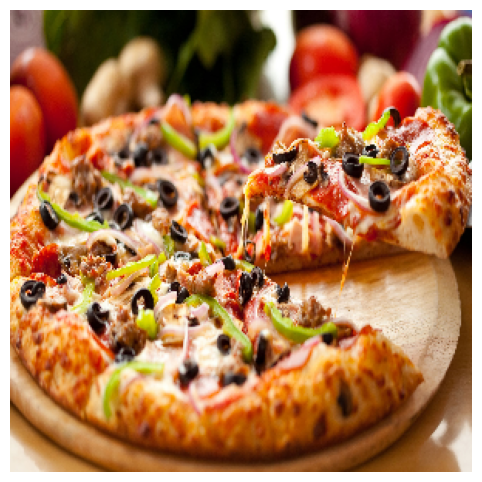

Сгенерированные описания:
  1. a pizza with a white plate with cheese , and a white plate of food on it .
  2. a pizza topped with lots of pizza and some wine .
  3. a pizza with a slice of pizza on it .
  4. a pizza with a pizza on it on a plate .
  5. a pizza sitting on top of a table on a table .


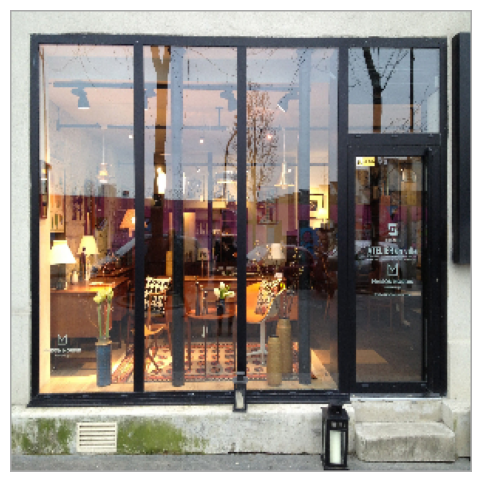

Сгенерированные описания:
  1. a group of people are standing around a large building .
  2. a big blue and white photo of a building .
  3. a red fire hydrant is shown with a light .
  4. a couple of green and white bus are sitting in the middle of some trees .
  5. a group of people walking in a city


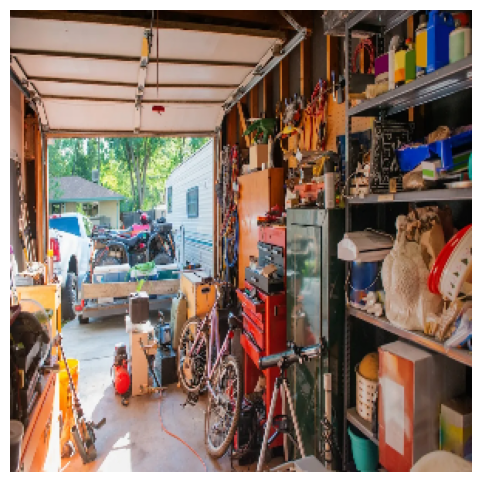

Сгенерированные описания:
  1. a large group of people sitting on a train .
  2. a group of people that are standing in a city .
  3. a woman is sitting in the middle of a station .
  4. a bunch of people in various bikes in the rain .
  5. a man with a black and blue umbrella in the background .


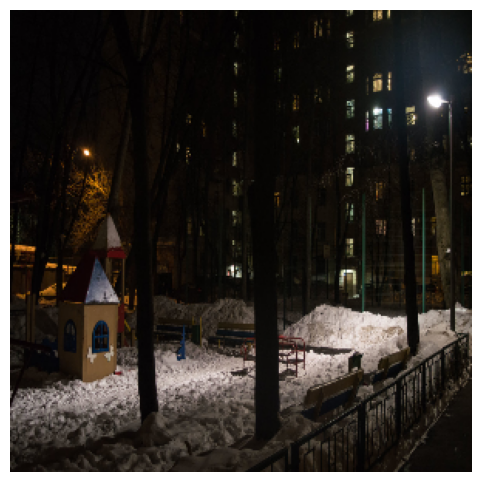

Сгенерированные описания:
  1. a black and white photo of a street with a red light .
  2. a red and white train is going down a hill .
  3. a red and white fire hydrant is in the snow .
  4. a red train is on a city street .
  5. a street scene with a tree , and a sign in the background .


In [174]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import os
%matplotlib inline

image_paths = [
    'data/img1.jpg', 'data/img2.jpg', 'data/img3.jpg', 
    'data/img4.jpg', 'data/img5.jpg', 'data/img6.jpg',
    'data/img7.jpg', 'data/img8.jpg', 'data/img9.jpg',
    'data/img10.jpg', 
]

for i, img_path in enumerate(image_paths, 1):
    if not os.path.exists(img_path):
        continue
 
    # Загрузка и подготовка изображения
    sample_image = plt.imread(img_path)
    
    img = cv2.resize(sample_image, (299, 299))
    
    # Нормализация
    if img.dtype == np.uint8:
        img = img.astype(np.float32) / 255.0
    elif img.max() > 1.0:
        img = img.astype(np.float32) / 255.0
    
    # Отображение
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # Генерация caption
    print("Сгенерированные описания:")
    for j in range(5):  # По 5 описаний на изображение
        caption = generate_caption(network, img, t=0.5)
        caption_text = ' '.join(caption[1:-1])  
        print(f"  {j+1}. {caption_text}")

Модель неплохо справляется с базовыми случаями, но если объекты занимают неестественное положение (например собака на 3-й фотке), сразу начинаются ошибки. Собаку считают жирафом или коровой, а человека и вовсе не могут распознать. Та же история с кафе или гаражом, где на фотографии есть блики или награмождение предметов без возможности выделить главный, модель теряется и видит людей там, где их нет